# Get score and variance for each move in game
Parse pgn (once converted to single lines) to get list of stockfish score and variance after each move, then split into black and white

## Read in packages, graph, and functions

In [1]:
from collections import defaultdict
import sys
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import chess
import subprocess
import timeit
import pickle
import stockfish
from stockfish import Stockfish
import chess
import chess.engine
import warnings
warnings.filterwarnings('ignore')

engine = chess.engine.SimpleEngine.popen_uci("../stockfish-10-64")
stockfish = Stockfish("../stockfish-10-64")

In [2]:
g = nx.read_gpickle('../Directed_Graphs/full690k.gpickle')

In [3]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var
    
def get_score(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    score = engine.analyse(board, chess.engine.Limit(time=.05), info=chess.engine.INFO_SCORE)
    if('#' in str(score['score'])):
        if('-' in str(score['score'])):
            return -39765
        else:
            return 39765
    else:
        score = int(str(score["score"]))
    return score

def san_to_fen(san):
    board = chess.Board()
    for move in san:
        try:
            board.push_san(move)
        except:
            break
    currFen = board.fen()
    return currFen

def get_node_sd(node):
    scores = []
    counts = []
    try:
        for neighbor in list(g.neighbors(node)):
            scores.append(nx.get_node_attributes(g, 'score')[neighbor])
            counts.append(nx.get_node_attributes(g, 'movelistCount')[neighbor][node])
        return node, np.sqrt(varWeighted(scores,counts))
    except:
        return node, None

## Read in pgn file

In [4]:
my_file = open("pgnparse.txt", "r")
pgn = my_file.read()

pgn_list = pgn.split("\n")
my_file.close()
print(len(pgn_list))

pgn_list = list(filter(None, pgn_list))
print(len(pgn_list))

242666
121332


In [5]:
pgn_list[1]

'[Event "Rated Classical game"  [Site "https://lichess.org/a9tcp02g"  [White "Desmond_Wilson"  [Black "savinka59"  [Result "1-0"  [UTCDate "2012.12.31"  [UTCTime "23:04:12"  [WhiteElo "1654"  [BlackElo "1919"  [WhiteRatingDiff "+19"  [BlackRatingDiff "-22"  [ECO "D04"  [Opening "Queen\'s Pawn Game: Colle System, Anti-Colle"  [TimeControl "480+2"  [Termination "Normal"   [mainline 1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nxg6 hxg6 6. Nd2 e6 7. Bd3 Bd6 8. e4 dxe4 9. Nxe4 Rxh2 10. Ke2 Rxh1 11. Qxh1 Nc6 12. Bg5 Ke7 13. Qh7 Nxd4+ 14. Kd2 Qe8 15. Qxg7 Qh8 16. Bxf6+ Kd7 17. Qxh8 Rxh8 18. Bxh8 1-0  '

## Create Dataframe from pgn file by splitting into dictionary of headers and values

In [6]:
start = timeit.default_timer()
d = defaultdict(list)
cnt = 0
for item in pgn_list:
    l = item.split('[mainline')
    try:
        info = l[0].split('"')
        #mainline = l[1]
        tuples = list(zip(info[::2],info[1::2]))
        tuples.append(('mainline', l[1]))

        for a, b in tuples:
            d[a].append(b)

        
    except:
         print('problem parsing:', item)
print("TIME:", timeit.default_timer()- start)

TIME: 0.874154785


In [7]:
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
print(df.shape)
df.head(2)

(121332, 18)


,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,[BlackRatingDiff,[ECO,[Opening,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,-8,C00,French Defense: Normal Variation,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM


#### Split san into list of moves (remove decimals)

In [8]:
df['san'] = df.mainline.apply(lambda x: [ i for i in x.split() if "." not in i ])

In [9]:
df.head(2)

,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,[BlackRatingDiff,[ECO,[Opening,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle,san
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,-8,C00,French Defense: Normal Variation,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6..."
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,-22,D04,"Queen's Pawn Game: Colle System, Anti-Colle",480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx..."


## Function to get score and Variance 
for each move in san, then split by black and white

In [10]:
def get_sd_score_from_san(san):
    board = chess.Board()
    sd_list = []
    score_list = []
    for move in san:
        try:
            board.push_san(move)
            currFen = board.fen()
            board = chess.Board(currFen)
            sf = engine.analyse(board, chess.engine.Limit(time=0.05))
            
            if('#' in str(sf['score'])):
                if('-' in str(sf['score'])):
                    sf =  -39765
                else:
                    sf =  39765
            else:
                sf = int(str(sf["score"]))*-1
            score_list.append(sf)
            scores = []
            counts = []
            for neighbor in list(g.neighbors(currFen)):
                scores.append(nx.get_node_attributes(g, 'score')[neighbor])
                counts.append(nx.get_node_attributes(g, 'count')[neighbor])

            sd_list.append(np.sqrt(varWeighted(scores, counts)))
        except:
            break
    return pd.Series([sd_list[::2],sd_list[1::2], score_list[::2],score_list[1::2]]) 
        ##white, black sd, white, black score
#     return(sd_list, score_list)

In [ ]:
#### Build a small dataframe to test on... this is super slow

In [11]:
df_test = df.head(1000)

In [12]:
# df_small['sd_list'] = df.san.apply(lambda x: get_sd_score_from_san(x)[0])
# df_small['sf_list'] = df.san.apply(lambda x: get_sd_score_from_san(x)[1])
start = timeit.default_timer()
df_test[['sd_white', 'sd_black','score_white', 'score_black']] = df_test.san.apply(
    lambda x: get_sd_score_from_san(x))
print("TIME:",timeit.default_timer()-start)
df_test.head(2)

TIME: 785.990168188


,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,...,[TimeControl,[Termination,mainline,[BlackTitle,[WhiteTitle,san,sd_white,sd_black,score_white,score_black
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,...,600+8,Normal,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6...","[28.708603722120852, 37.04284754927736]","[56.44575414848348, 39.24433474773549]","[77, 54, 90]","[-72, -170]"
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,...,480+2,Normal,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx...","[46.49596859748773, 38.75231615526675, 19.0918...","[37.02046744780591, 21.913376695108]","[7, 44, 11]","[-76, -62, -53]"


In [13]:
df_test['max_white_sd'] = df_test.sd_white.apply(lambda x: 0 if len(x) == 0 else max(x))
df_test['max_black_sd'] = df_test.sd_black.apply(lambda x: 0 if len(x) == 0 else max(x))

In [14]:
df_test.head(2)

,[Event,[Site,[White,[Black,[Result,[UTCDate,[UTCTime,[WhiteElo,[BlackElo,[WhiteRatingDiff,...,mainline,[BlackTitle,[WhiteTitle,san,sd_white,sd_black,score_white,score_black,max_white_sd,max_black_sd
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,2012.12.31,23:01:03,1639,1403,+5,...,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh...,LM,LM,"[e4, e6, d4, b6, a3, Bb7, Nc3, Nh6, Bxh6, gxh6...","[28.708603722120852, 37.04284754927736]","[56.44575414848348, 39.24433474773549]","[77, 54, 90]","[-72, -170]",37.042848,56.445754
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,2012.12.31,23:04:12,1654,1919,+19,...,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. N...,LM,LM,"[d4, d5, Nf3, Nf6, e3, Bf5, Nh4, Bg6, Nxg6, hx...","[46.49596859748773, 38.75231615526675, 19.0918...","[37.02046744780591, 21.913376695108]","[7, 44, 11]","[-76, -62, -53]",46.495969,37.020467


In [15]:
df_test.columns

Index(['[Event ', '  [Site ', '  [White ', '  [Black ', '  [Result ',
       '  [UTCDate ', '  [UTCTime ', '  [WhiteElo ', '  [BlackElo ',
       '  [WhiteRatingDiff ', '  [BlackRatingDiff ', '  [ECO ', '  [Opening ',
       '  [TimeControl ', '  [Termination ', 'mainline', '  [BlackTitle ',
       '  [WhiteTitle ', 'san', 'sd_white', 'sd_black', 'score_white',
       'score_black', 'max_white_sd', 'max_black_sd'],
      dtype='object')

In [16]:
df_test['  [WhiteElo '] = df_test['  [WhiteElo '].apply(pd.to_numeric)
df_test['  [BlackElo '] = df_test['  [BlackElo '].apply(pd.to_numeric, errors= 'coerce')
df_test['elo_diff'] = df_test['  [WhiteElo '] - df_test['  [BlackElo ']

CORR: 0.01466321889171192


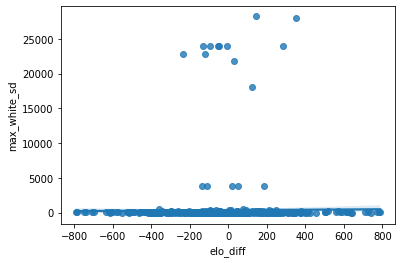

In [20]:
%matplotlib inline
import seaborn as sns
print("CORR:",df_test['elo_diff'].corr(df_test['max_white_sd']))
ax = sns.regplot('elo_diff' , 'max_white_sd', data = df_test)
#plt.ylim(0,400)

CORR: nan


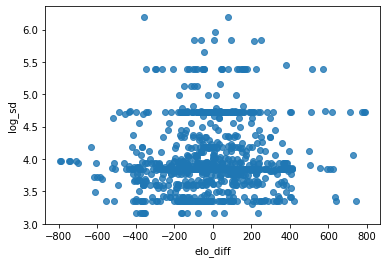

In [26]:
df_test2 = df_test[df_test['max_white_sd'] <500]
df_test2['log_sd'] = df_test2.max_white_sd.apply(lambda x: np.log(x))
print("CORR:",df_test2['elo_diff'].corr(df_test2['log_sd']))
ax = sns.regplot('elo_diff' , 'log_sd', data = df_test2)